In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 40.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from pathlib import Path
import os 
from keras.preprocessing.image import ImageDataGenerator

batch_size = 1
img_size = 72
num_classes = 7
input_shape = (img_size, img_size, 3)

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/mark 2 (V3)/dataset_flowers_350_images_7_classes/train'))) 

download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/mark 2 (V3)/dataset_flowers_350_images_7_classes')

train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'    

datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_directory(
                      train_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

valid_generator = datagen.flow_from_directory(
                      val_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

test_generator = datagen.flow_from_directory(
                      test_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [4]:
def extract_x_y(gen):
  x = []
  y = []
  x, y = next(gen)
  for i in range(len(gen)-1):
    x = np.append(x, gen[i+1][0], axis=0)
    y = np.append(y, gen[i+1][1], axis=0)
  return x, y

x_test,y_test = extract_x_y(test_generator)
x_valid,y_valid = extract_x_y(valid_generator)
x_train,y_train = extract_x_y(train_generator)

In [5]:
print("before reshape: ")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_valid shape: {x_test.shape} - y_valid shape: {y_test.shape}")

y_test = y_test.reshape((35,1))
y_valid = y_valid.reshape((35,1))
y_train = y_train.reshape((280,1))
y_test = y_test.astype(int)
y_valid = y_valid.astype(int)

print("\n\nafter reshape: ")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_valid shape: {x_test.shape} - y_valid shape: {y_test.shape}")

before reshape: 
x_train shape: (280, 72, 72, 3) - y_train shape: (280,)
x_test shape: (35, 72, 72, 3) - y_test shape: (35,)
x_valid shape: (35, 72, 72, 3) - y_valid shape: (35,)


after reshape: 
x_train shape: (280, 72, 72, 3) - y_train shape: (280, 1)
x_test shape: (35, 72, 72, 3) - y_test shape: (35, 1)
x_valid shape: (35, 72, 72, 3) - y_valid shape: (35, 1)


In [6]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [1000, 500]  # Size of the dense layers of the final classifier


In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [10]:
def create_model():
    inputs = layers.Input(input_shape)
    x = layers.RandomCrop(img_size, img_size)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    # Create patches.
    patches = Patches(patch_size)(x)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    outputs = layers.Dense(num_classes,activation="softmax")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model


In [11]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=80,
    validation_data=(x_test,y_test),
    callbacks=[checkpoint_callback],
)

model.load_weights(checkpoint_filepath)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 random_crop (RandomCrop)       (None, 72, 72, 3)    0           ['input_1[0][0]']                
                                                                                                  
 random_flip (RandomFlip)       (None, 72, 72, 3)    0           ['random_crop[0][0]']            
                                                                                                  
 patches (Patches)              (None, None, 108)    0           ['random_flip[0][0]']            
                                                                                              

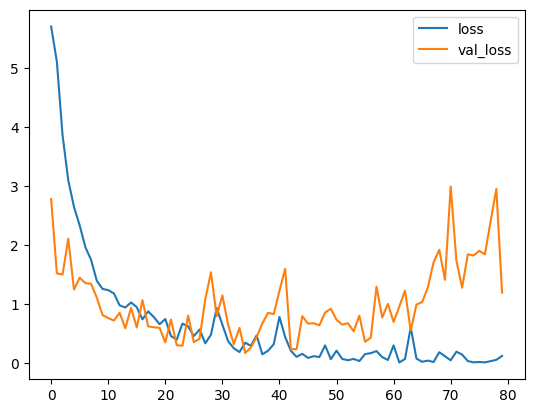

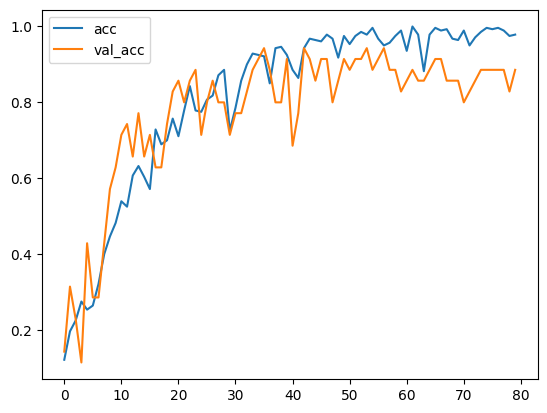

In [12]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()


2/2 [==============================] - 0s 14ms/step
Precisão: 0.9428571428571428


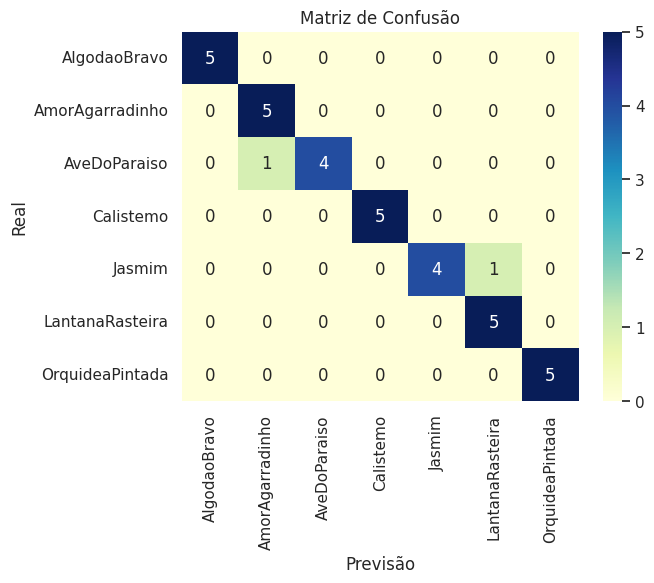

In [17]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gerar previsões para o conjunto de dados de validação
predictions = model.predict(x_test)

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions,axis=1)
predicted_classes = predicted_classes.reshape((35,1))

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = y_test

# Obter os nomes das classes
class_names = list(train_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [14]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

2/2 [==============================] - 0s 23ms/step - loss: 0.2620 - accuracy: 0.9429 - top-5-accuracy: 1.0000
Test loss: 0.26
Test accuracy: 94.29%
Test top 5 accuracy: 100.0%


2/2 [==============================] - 0s 14ms/step
Precisão: 0.8571428571428571


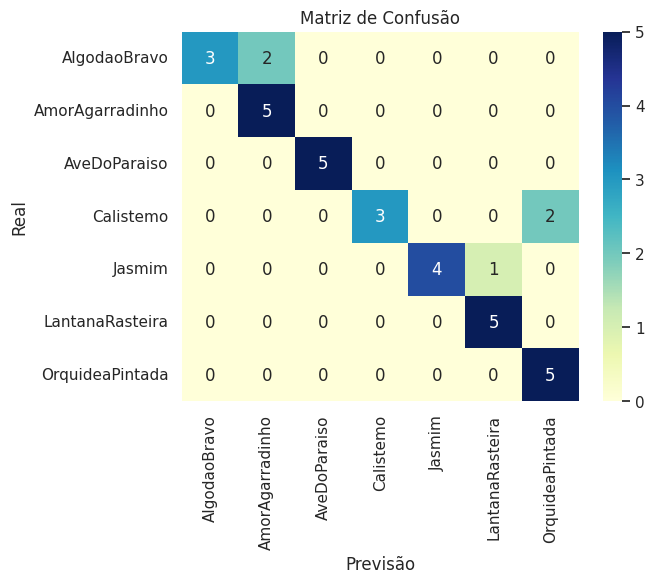

In [18]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gerar previsões para o conjunto de dados de validação
predictions = model.predict(x_valid)

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions,axis=1)
predicted_classes = predicted_classes.reshape((35,1))

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = y_valid

# Obter os nomes das classes
class_names = list(train_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [16]:
loss, accuracy, top_5_accuracy = model.evaluate(x_valid, y_valid)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


2/2 [==============================] - 0s 20ms/step - loss: 1.7154 - accuracy: 0.8571 - top-5-accuracy: 1.0000
Test loss: 1.72
Test accuracy: 85.71%
Test top 5 accuracy: 100.0%
